## Trabalho Final - MBA Inteligência Artificial e Machine Learning
FIAP 2022~2023


## Lógica usada neste trabalho
Existem alguns problemas principais neste dataset:
    * Muitos nulos
    * Algumas variáveis não são 'inputáveis' por virem de outros setores da empresa
    * Alta correlação entre colunas
Portanto, será necessário realizar uma redução de dimensionalidade e tratamento dos dados, primeiramente em colunas que indicam informações que passaram por outros setores da empresa, de forma a permitir um retorno automatizado.

### Fluxo:
* Redução da dimensionalidade em colunas que expressem dados de outros processos e com alta correlação
* Tratamento de nulos
* Feature engineering 
* Clusterização de empresas
* Análise de características dos clusters
* Aplicação dos clusters no dataframe
* Escrita do melhor modelo de clusterização em pickle
* LabelEncoding do dataframe
* StandardScaling do dataframe
* Remoção de outliers
* Treino e teste de modelos com GridSearch
* Escrita dos melhores modelos em pickle


In [1]:
#imports
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import json
import datetime
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans 
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('bootcamp-solicitacoescredito.csv')
pd.set_option('display.max_columns', df.shape[1])
pd.set_option('display.max_rows', 50)

df

,numero_solicitacao,razaoSocial,nomeFantasia,cnpjSemTraco,maiorAtraso,margemBrutaAcumulada,percentualProtestos,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,status,definicaoRisco,diferencaPercentualRisco,percentualRisco,dashboardCorrelacao,valorAprovado,dataAprovadoEmComite,periodoBalanco,ativoCirculante,passivoCirculante,totalAtivo,totalPatrimonioLiquido,endividamento,duplicatasAReceber,estoque,faturamentoBruto,margemBruta,periodoDemonstrativoEmMeses,custos,anoFundacao,intervaloFundacao,capitalSocial,restricoes,empresa_MeEppMei,scorePontualidade,limiteEmpresaAnaliseCredito,dataAprovadoNivelAnalista
0,1,James Richardson-Patel,Alexandra Williams,KEBE17609492220843,0,0.252448,0.0,2015-12-10T00:00:00,0,0.00,50000.0,AprovadoAnalista,De 11 a 30 % - Baixo,0.716981,0.283019,0.000000,50000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1766880.0,0.0,12.0,0.0,2003.0,Acima de 17 anos,90000.0,False,True,1.000000,43200.0,2020-02-03T20:57:33
1,2,Dr. Geoffrey Walsh,Mr. Darren Arnold,JRBK88908250677300,0,0.000000,NaN,2019-06-12T17:28:31,0,0.00,10000.0,DocumentacaoReprovada,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,3,Joanna Hudson,Dr. David Rees,GCVQ28531614261293,4,0.624777,0.0,2019-11-27T00:00:00,0,0.00,20000.0,AprovadoAnalista,De 11 a 30 % - Baixo,0.716981,0.283019,0.000000,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2814940.0,0.0,7.0,0.0,2014.0,De 6 a 10 anos,20000.0,False,True,1.000000,4320.0,2020-02-04T16:40:49
3,4,Gordon Jones-Hopkins,Sara Reid-Robson,KJND32266018316396,20,0.000000,NaN,2017-02-13T17:20:27,0,0.00,25000.0,AprovadoAnalista,De 51 a 80 % - Alto,0.396226,0.603774,0.485811,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1285274.0,0.0,12.0,0.0,2013.0,De 6 a 10 anos,30000.0,False,True,0.000000,5920.0,2020-02-04T16:37:52
4,5,Nigel Lee,Dr. Stanley Duncan,CGQN15826802440348,20,0.454088,0.0,2010-07-13T00:00:00,20,1486.95,50000.0,AprovadoAnalista,De 11 a 30 % - Baixo,0.830189,0.169811,0.000000,50000.0,NaN,2019-09-30T00:00:00,14758917.0,12149031.0,25793410.0,14544378.0,3039112.0,11797928.0,3047791.0,40779757.0,81459809.0,9.0,40680051.0,2002.0,Acima de 17 anos,75000.0,False,False,1.000000,89000.0,2020-02-04T15:06:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8968,9041,Leah Williams,Georgia Booth,YKGZ02907098931653,149,0.306580,0.0,2006-04-26T00:00:00,59,599964.04,900000.0,EmAnaliseDocumentacao,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.990876,NaN,NaN
8969,9042,Mr. Jordan Stevens,Miss Ellie Kelly,UCBM91111020900951,23,0.329796,0.0,2016-08-03T00:00:00,0,0.00,150000.0,EmAnaliseDocumentacao,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.958869,NaN,NaN
8970,9043,Mr. Barry Wells,Danielle Hudson,CLDB61185288622179,3,0.383919,0.0,2018-10-25T00:00:00,4,2933.38,150000.0,EmAnaliseDocumentacao,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
8971,9044,Keith Jones,Steven Kennedy-Jones,BRJP37453437154592,11,0.424099,0.0,2011-08-10T00:00:00,31,559679.98,1290000.0,EmAnaliseDocumentacao,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.994786,NaN,NaN


In [3]:
#carregando dicionário de dados
with open ('descricao_colunas.json', 'r') as jsonfile:
    dict_desc_colunas = json.load(jsonfile)
for item in sorted(dict_desc_colunas):
    print (item+':', dict_desc_colunas[item])

anoFundacao: Ano de fundação da empresa
ativoCirculante: Ativo circulante informado na documentação da empresa
capitalSocial: Capital social informado na documentação da empresa
cnpjSemTraco: CNPJ Anonimizado
custos: Custos informado na documentação da empresa
dashboardCorrelacao: uma correlação interna de risco, mas que os analistas não conseguiram explicar nas reuniões realizadas
dataAprovadoEmComite: data em que a solicitação de crédito foi aprovada por um comitê
dataAprovadoNivelAnalista: data em que a solicitação de crédito foi aprovada por um analista de crédito
definicaoRisco: categorização de risco
diferencaPercentualRisco: 1- percentual Risco
duplicatasAReceber: Duplicatas a receber informado na documentação da empresa
empresa_MeEppMei: Flag informando se o cliente é um pequeno negócio
endividamento: Endividamento informado na documentação da empresa
estoque: estoque Informado na documentação da empresa
faturamentoBruto: Faturamento bruto informado na documentação da empresa
i

In [4]:
print ('Porcentagem de valores cedidos em relação a solicitados:',
       round((df['valorAprovado']/df['valorSolicitado']).mean(),2))

Porcentagem de valores cedidos em relação a solicitados: 0.83


###### __Dimensionalidade e Correlação__
Verificando a possibilidade de dropar colunas com alta correlação e que não atendem a necessidade de propor valor de crédito de forma automatizada, reduzindo o dataset.

###### __mapeando correlações__

ρ = 0,9 a 1 (positivo ou negativo): correlação muito forte;

ρ = 0,7 a 09 (positivo ou negativo): correlação forte;

ρ = 0,5 a 0,7 (positivo ou negativo): correlação moderada;

ρ = 0,3 a 0,5 (positivo ou negativo): correlação fraca;

ρ = 0 a 0,3 (positivo ou negativo): não possui correlação.

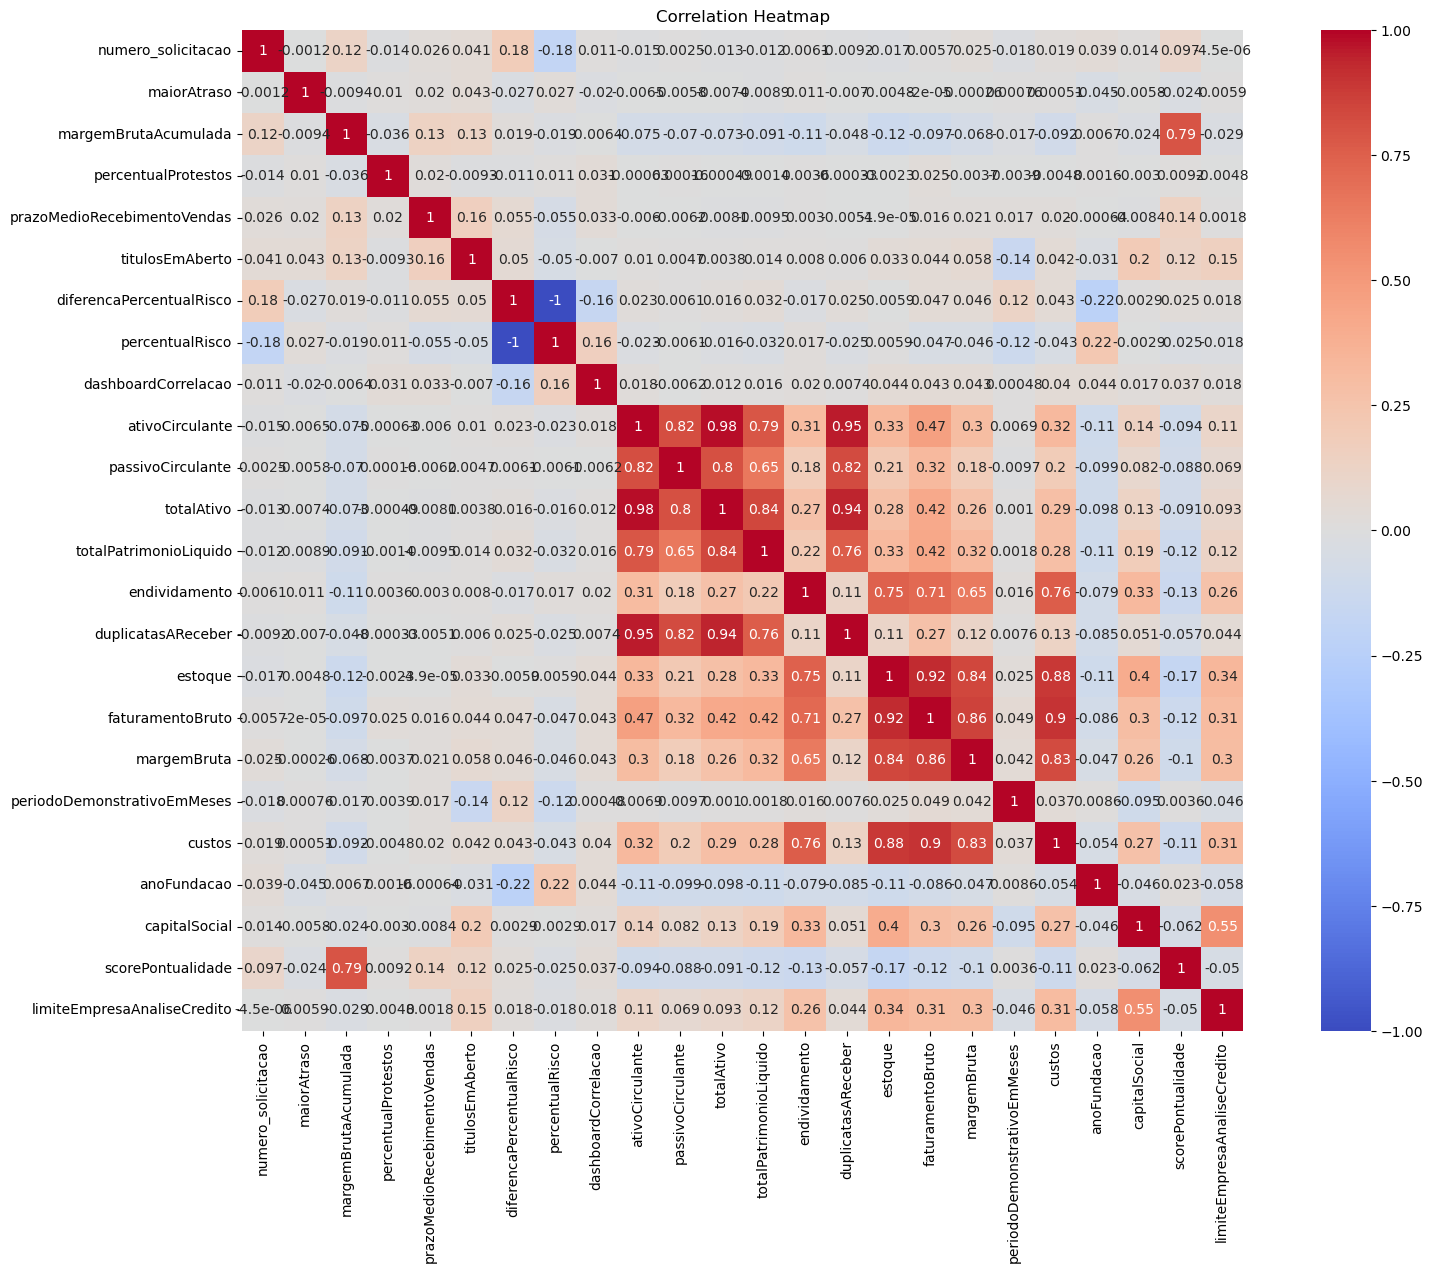

In [5]:
#verificando alta correlação em variáveis independentes
# dropando valorSolicitado da análise por ser dado de entrada muito importante
def verifica_correlacao(df):
    corr_matrix = df.drop(columns=['valorSolicitado','valorAprovado']).corr() 
    plt.figure(figsize=(20, 13))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
    plt.title('Correlation Heatmap')
    plt.show()
    return corr_matrix
corr_matrix = verifica_correlacao(df)

Notamos acima muitas colunas com alta correlação. Veremos quais são.

In [6]:
#buscando maiores correlações
colunas_alta_correlacao = {}
for row_idx, row in corr_matrix.iterrows():
    dict_row = {}
    for col in corr_matrix.columns:
        if col != row_idx:
            dict_row.update({row[col]:col})
    score_correlacao_ascendente = []
    for corr_score in sorted(dict_row, reverse=True):
        score_correlacao_ascendente.append(dict_row[corr_score])
    colunas_alta_correlacao.update({row_idx:score_correlacao_ascendente})
df_correlacao_ordenada = pd.DataFrame.from_dict(colunas_alta_correlacao).T
df_correlacao_ordenada = df_correlacao_ordenada[[0,1,2]]
df_correlacao_ordenada.sort_index(inplace=True)
df_correlacao_ordenada.columns = ['maior', 'segunda_maior', 'terceira_maior']
df_correlacao_ordenada

,maior,segunda_maior,terceira_maior
anoFundacao,percentualRisco,dashboardCorrelacao,numero_solicitacao
ativoCirculante,totalAtivo,duplicatasAReceber,passivoCirculante
capitalSocial,limiteEmpresaAnaliseCredito,estoque,endividamento
custos,faturamentoBruto,estoque,margemBruta
dashboardCorrelacao,percentualRisco,estoque,anoFundacao
diferencaPercentualRisco,numero_solicitacao,periodoDemonstrativoEmMeses,prazoMedioRecebimentoVendas
duplicatasAReceber,ativoCirculante,totalAtivo,passivoCirculante
endividamento,custos,estoque,faturamentoBruto
estoque,faturamentoBruto,custos,margemBruta
faturamentoBruto,estoque,custos,margemBruta


###### __Vamos então dropar as seguintes:__
* ativoCirculante - parece estar melhor representada pelo totalAtivo
* passivoCirculante - muita correlação com ativoCirculante
* estoque - tem alta correlação com capitalSocial e faturamentoBruto
* custos - tem alta correlação com capitalSocial e faturamentoBruto
* duplicatasAReceber - tem alta correlação com totalAtivo
* totalPatrimonioLiquido - muita correlação com totalAtivo 
* endividamento - muita correlação com faturamentoBruto
* margemBruta - muita correlação com faturamentoBruto
* numero_solicitacao - número de linha, não faz sentido para ML. - _Este dado será mantido para a etapa seguinte e então dropado_.
* razaoSocial - CNPJ é PK
* nomeFantasia - CNPJ é PK
* maiorAtraso - dado impossível de inputar para novos clientes
* margemBrutaAcumulada - não faz sentido para ML
* percentualProtestos - baseado em dado externo
* status - baseado em dado externo
* definicaoRisco - baseado em dado externo
* diferencaPercentualRisco - baseado em dado externo
* percentualRisco - baseado em dado externo
* dashboardCorrelacao - baseado em dado externo
* dataAprovadoEmComite - baseado em dado externo
* anoFundacao - existe coluna categórica intervaloFundacao que permitiria segmentacao
* restricoes - baseado em dado externo
* scorePontualidade - baseado em dado externo
* limiteEmpresaAnaliseCredito - baseado em dado externo
* dataAprovadoNivelAnalista - baseado em dado externo
* dataAprovadoNivelAnalista - baseado em dado externo

In [7]:
#lendo novamente o dataframe, aplicando drop e colocando coluna target como última
df = pd.read_csv('bootcamp-solicitacoescredito.csv')
a_dropar = [
            'ativoCirculante',
            'passivoCirculante',
            'estoque',
            'custos',
            'duplicatasAReceber',
            'totalPatrimonioLiquido',
            'endividamento',
            'margemBruta',
            'razaoSocial',
            'nomeFantasia',
            'maiorAtraso',
            'margemBrutaAcumulada',
            'percentualProtestos',
            'status',
            'definicaoRisco',
            'diferencaPercentualRisco',
            'percentualRisco',
            'dashboardCorrelacao',
            'dataAprovadoEmComite',
            'anoFundacao',
            'restricoes',
            'scorePontualidade',
            'limiteEmpresaAnaliseCredito',
            'dataAprovadoNivelAnalista',
            'dataAprovadoNivelAnalista'
            ]

for col in sorted(a_dropar):
    print ('DROP '+col+' --  ' + dict_desc_colunas[col])

df = df.drop(columns=a_dropar)
df = df[['numero_solicitacao', 'cnpjSemTraco', 'primeiraCompra',
       'prazoMedioRecebimentoVendas', 'titulosEmAberto', 'valorSolicitado',
       'periodoBalanco', 'totalAtivo', 'faturamentoBruto',
       'periodoDemonstrativoEmMeses', 'intervaloFundacao', 'capitalSocial',
       'empresa_MeEppMei','valorAprovado']] #reordenando colunas para target ser a última

DROP anoFundacao --  Ano de fundação da empresa
DROP ativoCirculante --  Ativo circulante informado na documentação da empresa
DROP custos --  Custos informado na documentação da empresa
DROP dashboardCorrelacao --  uma correlação interna de risco, mas que os analistas não conseguiram explicar nas reuniões realizadas
DROP dataAprovadoEmComite --  data em que a solicitação de crédito foi aprovada por um comitê
DROP dataAprovadoNivelAnalista --  data em que a solicitação de crédito foi aprovada por um analista de crédito
DROP dataAprovadoNivelAnalista --  data em que a solicitação de crédito foi aprovada por um analista de crédito
DROP definicaoRisco --  categorização de risco
DROP diferencaPercentualRisco --  1- percentual Risco
DROP duplicatasAReceber --  Duplicatas a receber informado na documentação da empresa
DROP endividamento --  Endividamento informado na documentação da empresa
DROP estoque --  estoque Informado na documentação da empresa
DROP limiteEmpresaAnaliseCredito --  lim

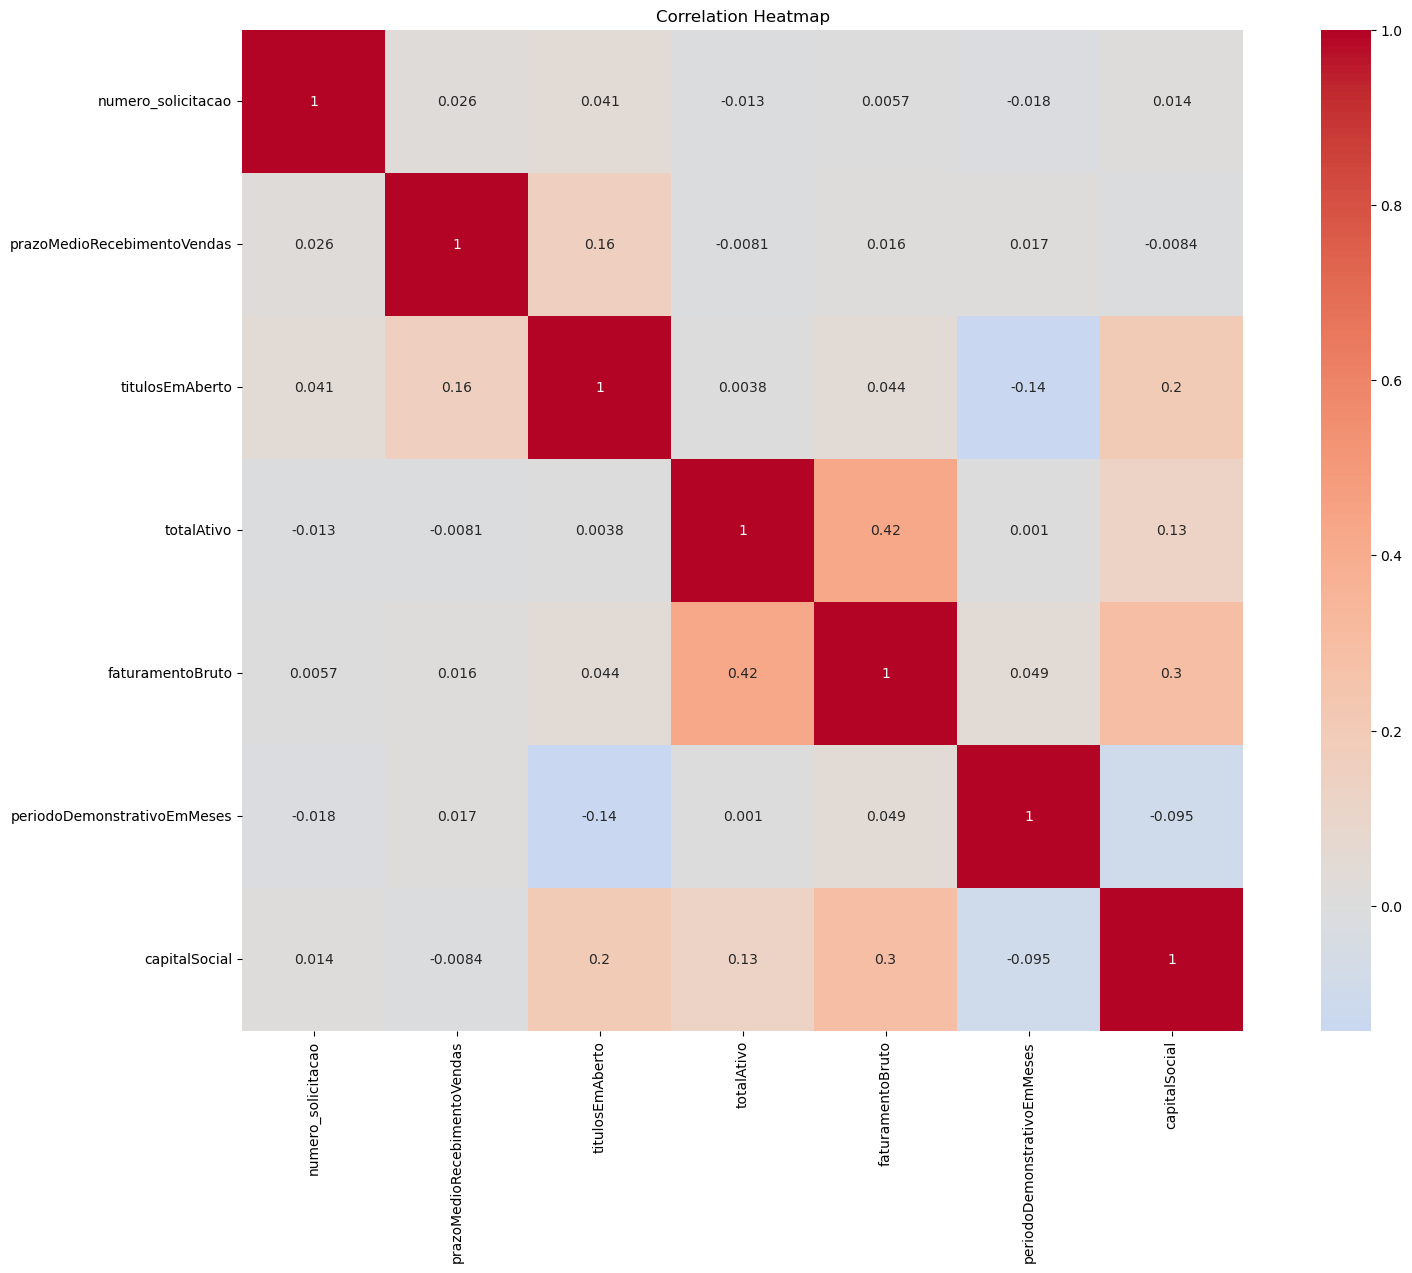

In [8]:
# observando df após drop
corr_matrix = verifica_correlacao(df)

In [9]:
#colunas que ficaram
for col in sorted(df.columns):
    print (col+' --  ' + dict_desc_colunas[col])

capitalSocial --  Capital social informado na documentação da empresa
cnpjSemTraco --  CNPJ Anonimizado
empresa_MeEppMei --  Flag informando se o cliente é um pequeno negócio
faturamentoBruto --  Faturamento bruto informado na documentação da empresa
intervaloFundacao --  Categoria do ano de fundação
numero_solicitacao --  Número da solicitação
periodoBalanco --  Período do balanço informado na documentação da empresa
periodoDemonstrativoEmMeses --  Período do demonstrativo informado na documentação da empresa
prazoMedioRecebimentoVendas --  prazo médio do recebimento de vendas do cliente
primeiraCompra --  Data da primeira compra na Wtec
titulosEmAberto --  valor total de títulos em aberto
totalAtivo --  Ativo informado na documentação da empresa
valorAprovado --  Valor que foi aprovado pelos analistas
valorSolicitado --  valor de crédito solicitado


###### __Tratando Nulos__
Verificando a possibilidade de aproveitar um dado não-nulo de uma empresa (de uma solicitação de crédito) em uma linha que tenha este mesmo dado nulo (em outra solicitação)

In [10]:
#nulos
df.isna().sum()/df.shape[0]

numero_solicitacao             0.000000
cnpjSemTraco                   0.000000
primeiraCompra                 0.011813
prazoMedioRecebimentoVendas    0.000000
titulosEmAberto                0.000000
valorSolicitado                0.000000
periodoBalanco                 0.472529
totalAtivo                     0.472529
faturamentoBruto               0.083584
periodoDemonstrativoEmMeses    0.083584
intervaloFundacao              0.083027
capitalSocial                  0.083027
empresa_MeEppMei               0.083027
valorAprovado                  0.156469
dtype: float64

Vamos tratar a variável resposta e eliminar os NaN's.

In [11]:
#realizando exclusão de valores não aprovados (NaN em valorAprovado)
df.dropna(subset='valorAprovado', inplace=True)

Observando empresas com nulos

In [12]:
#verificando se alguns dos dados nulos estão sob o mesmo CNPJ em outras linhas
empresas = df['cnpjSemTraco'].unique()
print (str(len(empresas))+' empresas no dataset')
indice_sem_balanco = df.loc[(df['totalAtivo'].isnull())].index
contagem_por_empresa = df['cnpjSemTraco'].value_counts()
nulos_por_empresa_campo = df[['cnpjSemTraco','totalAtivo']]
nulos_por_empresa_campo['null'] = ~nulos_por_empresa_campo['totalAtivo']\
                                            .notnull()\
                                            .astype(bool)
nulos_por_empresa_campo = nulos_por_empresa_campo.drop(columns = ['totalAtivo'])


nulos_por_empresa = nulos_por_empresa_campo.groupby(by='cnpjSemTraco').sum()
nulos_por_empresa['contagem_por_empresa'] = contagem_por_empresa
nulos_por_empresa['pct_nulos_totalAtivo'] = nulos_por_empresa['null'] / \
                                        nulos_por_empresa['contagem_por_empresa']
nulos_por_empresa[(nulos_por_empresa['pct_nulos_totalAtivo']>0) & (nulos_por_empresa['pct_nulos_totalAtivo']<1)]\
                    .sort_values('pct_nulos_totalAtivo', ascending = False)

2633 empresas no dataset


,null,contagem_por_empresa,pct_nulos_totalAtivo
cnpjSemTraco,,,
LPFJ21465680706778,8,9,0.888889
FOZQ39728582407424,7,8,0.875000
BFRW45357875791361,5,6,0.833333
XYOK79084874197647,4,5,0.800000
ESTG52141925374013,4,5,0.800000
...,...,...,...
XPVZ80447104399027,1,10,0.100000
NTPP27145676483888,1,11,0.090909
MIGR17953197952198,1,11,0.090909


###### Como existem empresas com colunas que estão nulas em apenas algumas linhas, vamos agora reordenar dataframe por empresa e número de solicitação e tratando NaN com backfill

In [13]:
#reordenando dataframe
df = df.sort_values(['cnpjSemTraco', 'numero_solicitacao'])\
                    .reset_index(drop=True).drop(columns = 'numero_solicitacao')
#quebrando dataframe em dicionarios
dict_empresas = {}
for empresa in empresas:
    dict_empresas.update({empresa:df[df['cnpjSemTraco']==empresa]})
#realizando o fillna por empresa usando ffill
for empresa in dict_empresas:
    dict_empresas[empresa] = dict_empresas[empresa].fillna(method='ffill')
#reconstruindo dataframe
lista_df = []
for empresa in dict_empresas:
    dict_empresas[empresa] = dict_empresas[empresa].fillna(method='ffill')
    lista_df.append(dict_empresas[empresa])
df2 = pd.concat(lista_df)
df2

,cnpjSemTraco,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,periodoBalanco,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,valorAprovado
3144,KEBE17609492220843,2015-12-10T00:00:00,0,0.0,50000.0,NaN,NaN,1766880.0,12.0,Acima de 17 anos,90000.0,True,50000.0
3145,KEBE17609492220843,2015-12-10T00:00:00,0,0.0,100000.0,2019-12-31T03:00:00,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,65000.0
3146,KEBE17609492220843,2015-12-10T00:00:00,0,0.0,120000.0,2019-12-31T03:00:00,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,65000.0
3147,KEBE17609492220843,2015-12-10T00:00:00,0,0.0,100000.0,2019-12-31T03:00:00,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,65000.0
1834,GCVQ28531614261293,2019-11-27T00:00:00,0,0.0,20000.0,NaN,NaN,2814940.0,7.0,De 6 a 10 anos,20000.0,True,20000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,DMNU57577101368941,2007-03-01T00:00:00,0,0.0,35000.0,NaN,NaN,1684508.0,12.0,Acima de 17 anos,10000.0,False,30000.0
3951,NCCP32868223153118,2020-08-24T00:00:00,27,9334.0,50000.0,2020-12-31T03:00:00,245257.0,384958.0,12.0,De 0 a 5 anos,30000.0,False,5000.0
3133,KBOS63147302240824,2017-02-13T16:41:03,0,0.0,50000.0,NaN,NaN,3410070.0,12.0,De 6 a 10 anos,200000.0,False,45000.0
2781,ISPY81393760117061,2019-05-16T00:00:00,0,0.0,200000.0,2019-12-31T03:00:00,2336218.0,1366363.0,12.0,De 0 a 5 anos,100000.0,True,15000.0


In [14]:
# observando resultados
df2_nulos = (df2.isna().sum()/df.shape[0]).sort_values(ascending = False)
df2_nulos = pd.concat([df.isna().sum()/df.shape[0],df2_nulos], axis=1)
df2_nulos.columns = ['df1', 'df2']
print ('Redução de nulos em', str(round((1-(df2_nulos['df2'].sum()/df2_nulos['df1'].sum()))*100,2))+'%.')
df2_nulos


Redução de nulos em 6.36%.


,df1,df2
cnpjSemTraco,0.000000,0.000000
primeiraCompra,0.006210,0.006210
prazoMedioRecebimentoVendas,0.000000,0.000000
titulosEmAberto,0.000000,0.000000
valorSolicitado,0.000000,0.000000
periodoBalanco,0.420267,0.393843
totalAtivo,0.420267,0.393843
faturamentoBruto,0.000528,0.000000
periodoDemonstrativoEmMeses,0.000528,0.000000
intervaloFundacao,0.000000,0.000000


###### _Como podemos ver acima, a quantidade de nulos no df2 foi reduzida em 6.09%._

Vamos rodar algoritmos de clusterização, inserir os labels no dataframe e então terminar de tratar NaN's com médias por cluster.

###### __Feature Engineering__

###### _transformando datas_
As datas estão no formato data-hora-minuto-segundo, vamos transformalas em colunas apartadas

In [15]:
def split_datas(df, cols):
    df = df.copy()
    for col in cols:
        for ymd in ['Y', 'm']:
            df[col+'_'+ymd] = df.loc[df[col].notnull(), col] \
                .apply(lambda x: int(datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S') \
                .strftime('%'+ymd)))
    df.drop(columns=cols, inplace=True)
    return df
df2 = split_datas(df2, ['primeiraCompra', 'periodoBalanco'])

###### _inserindo coluna com quantidades de solicitações de crédito_

In [16]:
df2["qtd_solic"] = df.groupby('cnpjSemTraco')['cnpjSemTraco'].rank(method="first", ascending=True)
df2[['cnpjSemTraco', 'qtd_solic']].head(10)

,cnpjSemTraco,qtd_solic
3144,KEBE17609492220843,1.0
3145,KEBE17609492220843,2.0
3146,KEBE17609492220843,3.0
3147,KEBE17609492220843,4.0
1834,GCVQ28531614261293,1.0
1835,GCVQ28531614261293,2.0
1836,GCVQ28531614261293,3.0
1837,GCVQ28531614261293,4.0
1838,GCVQ28531614261293,5.0
1839,GCVQ28531614261293,6.0


###### __Clusterização__

Antes da clusterização, precisamos aumentar o grão em um nível, de forma que cada linha expresse uma empresa. Isso facilitará na análise de clusters e permitirá que tratemos os NaN's ainda presentes com informações dos clusters.

Para isso, vamos então realizar o Label Encoding das variáveis do tipo Object para então agrupar em empresas usando a média das variáveis e rodar a clusterização.

In [17]:
def label_encode_write_json(df,ignore_cols = None, name = None):
    # transformando o dataframe com label encoder
    cols = list(df.columns)
    if ignore_cols != None:
        if type(ignore_cols) != list:
            ignore_cols = [ignore_cols]
        cols = set(cols)-set(ignore_cols)
    le = LabelEncoder()
    dict_label_encoder = {}
    for col in cols:
        if df[col].dtype == 'object':
            le.fit(df[col])
            df[col] = le.transform(df[col])
            for val in df[col].drop_duplicates():
                try:
                    dict_label_encoder[col].update({le.inverse_transform([val])[0]:val})
                except:
                    dict_label_encoder.update({col:{le.inverse_transform([val])[0]:val}})
    if name != None:
        try:
            os.mkdir('Models')
        except:
            pass
        with open ('Models/label_encoder_{name}.json'.format(name=name), 'w') as jsonfile:
            json.dump(dict_label_encoder, jsonfile)         
    return df

In [18]:
#construindo df_empresas
df_empresas = df2.copy()

#removendo colunas pouco pertinentes à 'persona' das emprsas
df_empresas = df_empresas.drop(columns = ['valorAprovado',
                                          'primeiraCompra_Y',
                                          'primeiraCompra_m',
                                          'periodoBalanco_Y',
                                          'periodoBalanco_m',
                                          'valorSolicitado'])

#label encoding e criação de inverse_transform para futuros clientes
df_empresas = label_encode_write_json(df_empresas, ignore_cols = 'cnpjSemTraco', name = '{cnt}col'\
                                                                  .format(cnt = df_empresas.shape[1]))
df_empresas

,cnpjSemTraco,prazoMedioRecebimentoVendas,titulosEmAberto,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,qtd_solic
3144,KEBE17609492220843,0,0.0,NaN,1766880.0,12.0,0,90000.0,True,1.0
3145,KEBE17609492220843,0,0.0,1876039.0,1818311.0,12.0,0,90000.0,True,2.0
3146,KEBE17609492220843,0,0.0,1876039.0,1818311.0,12.0,0,90000.0,True,3.0
3147,KEBE17609492220843,0,0.0,1876039.0,1818311.0,12.0,0,90000.0,True,4.0
1834,GCVQ28531614261293,0,0.0,NaN,2814940.0,7.0,3,20000.0,True,1.0
...,...,...,...,...,...,...,...,...,...,...
1078,DMNU57577101368941,0,0.0,NaN,1684508.0,12.0,0,10000.0,False,1.0
3951,NCCP32868223153118,27,9334.0,245257.0,384958.0,12.0,1,30000.0,False,1.0
3133,KBOS63147302240824,0,0.0,NaN,3410070.0,12.0,3,200000.0,False,1.0
2781,ISPY81393760117061,0,0.0,2336218.0,1366363.0,12.0,1,100000.0,True,1.0


In [19]:
#agrupando dataframe em empresas
df_empresas = df_empresas.groupby('cnpjSemTraco').agg({
    'prazoMedioRecebimentoVendas':'mean',
    'titulosEmAberto':'mean',
    'totalAtivo':'max',
    'faturamentoBruto':'max',
    'periodoDemonstrativoEmMeses':'mean',
    'intervaloFundacao':'max',
    'capitalSocial':'mean',
    'empresa_MeEppMei':'max',
    'qtd_solic':'max'
})

###### __Aplicando algoritmos de Clustering e escolhendo o melhor__
Utilizando o DBSCAN, KMeans e GaussianMixture para realizar clusterização do dataset df_empresas

In [20]:
#ainda existem nulos
df_empresas.isna().sum()

prazoMedioRecebimentoVendas       0
titulosEmAberto                   0
totalAtivo                     1181
faturamentoBruto                  0
periodoDemonstrativoEmMeses       0
intervaloFundacao                 0
capitalSocial                     0
empresa_MeEppMei                  0
qtd_solic                         0
dtype: int64

###### Tratando nulos restantes

In [21]:
#demonstrando volumetria antes e depois de dropna()
print (df_empresas.shape[0],'linhas atuais\n',df_empresas.dropna().shape[0],'linhas se dropna()')

2633 linhas atuais
 1452 linhas se dropna()


Ao usar o __dropna()__, perderíamos muitas linhas. 

Como as colunas que têm NaN no dataset de Empresas são de Ativo e de Capital Social, vamos verificar o que ocorre com os valores cedidos para empresas sem estas informações:

In [22]:
#total de crédito concedido para empresas com capitalSocial nulo
print ('dropna() em capitalSocial nos tira $'+ \
       str(df[df['capitalSocial'].isna()]['valorAprovado'].astype(float).sum()) + \
       ' da variavel-resposta.')

#total de crédito concedido para empresas com totalAtivo nulo
print ('dropna() em totalAtivo nos tira $'+ \
       str(df[df['totalAtivo'].isna()]['valorAprovado'].astype(float).sum()) + \
       ' da variavel-resposta.')

dropna() em capitalSocial nos tira $0.0 da variavel-resposta.
dropna() em totalAtivo nos tira $253344534.0 da variavel-resposta.


Portanto, é possível entender ser **necessário** manter informação de totalAtivo, porém não de capitalSocial.
Por conta disso, vamos **dropar** as linhas sem capitalSocial e transformar as NaN's de totalAtivo em 0 antes de realizar a clusterização.

De qualquer forma, a proposta é que **todas** as informações solicitadas sejam repassadas pelo cliente, e isso será reforçado pelo front-end da aplicação.

In [23]:
df_empresas.dropna(subset=['capitalSocial'], inplace = True)
df_empresas['totalAtivo'].fillna(0, inplace=True)

In [24]:
#confirmando não haverem nulos
for col in df_empresas.columns:
    df_empresas[col].fillna(df_empresas[col].mean(), inplace=True)
df_empresas.isna().sum()

prazoMedioRecebimentoVendas    0
titulosEmAberto                0
totalAtivo                     0
faturamentoBruto               0
periodoDemonstrativoEmMeses    0
intervaloFundacao              0
capitalSocial                  0
empresa_MeEppMei               0
qtd_solic                      0
dtype: int64

In [25]:
#dropando coluna de cnpj (indice)
df_empresas_com_cnpj = df_empresas.copy() # para uso posterior
df_empresas = df_empresas.reset_index(drop=True)

###### clusterizando
Aplicando DBSCAN

In [26]:
dbscan = DBSCAN(eps=3, min_samples=3)
dbscan.fit(df_empresas)
df_empresas_dbscan = df_empresas.copy()
df_empresas_dbscan['label'] = dbscan.labels_
print (len(df_empresas_dbscan['label'].unique()), 'clusters')
df_empresas_dbscan['label'].value_counts()/df_empresas_dbscan.shape[0]*100

10 clusters


-1    98.670718
 2     0.227877
 6     0.189897
 7     0.189897
 0     0.151918
 1     0.113938
 3     0.113938
 4     0.113938
 5     0.113938
 8     0.113938
Name: label, dtype: float64

Notamos acima que o DBSCAN gerou representatividade muito baixa em clusters que não o -1.

###### clusterizando

Aplicando K-Means

In [27]:
kmeans = KMeans(n_clusters=3, 
                max_iter=1000,
                tol=1e-4)

y_kmeans = kmeans.fit_predict(df_empresas)
df_empresas_kmeans = df_empresas.copy()
df_empresas_kmeans['label'] = y_kmeans
print (len(df_empresas_kmeans['label'].unique()), 'clusters')
df_empresas_kmeans['label'].value_counts()/df_empresas_kmeans.shape[0]*100

3 clusters


0    99.886062
2     0.075959
1     0.037979
Name: label, dtype: float64

Acima vemos o mesmo ocorrendo no K-Means

###### clusterizando
Aplicando GaussianMixture

In [28]:
gm = GaussianMixture(n_components=3, 
                     max_iter=1000, 
                     tol=1e-4,
                     init_params='random')
gm.fit(df_empresas)
y_gm = gm.predict(df_empresas)
df_empresas_gm = df_empresas.copy()
df_empresas_gm['label'] = y_gm
print (len(df_empresas_gm['label'].unique()), 'clusters')
df_empresas_gm['label'].value_counts()/df_empresas_gm.shape[0]*100

3 clusters


1    63.843524
2    27.838967
0     8.317509
Name: label, dtype: float64

Com GaussianMixture notamos uma distribuição melhor. Vamos salvar o modelo e então analisar os clusters com base nas features.

In [29]:
with open('Models/gm_clusterizer.pkl', 'wb') as picklefile:
    pickle.dump(gm, picklefile)

In [30]:
#função para analisar os clusters
def cluster_analysis(df, labelcol = 'label'):
    dict_cluster_means = {}
    clusters = df[labelcol].unique()
    for cluster in clusters:
        cluster_mean = df[df[labelcol]==cluster].drop(columns = [labelcol]).agg('mean').to_dict()
        dict_cluster_means.update({cluster:cluster_mean})
    display(pd.DataFrame(dict_cluster_means).T.sort_index())
cluster_analysis(df_empresas_gm)

,prazoMedioRecebimentoVendas,titulosEmAberto,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,qtd_solic
0,34.831050,238305.088767,6.430549e+08,5.432833e+08,9.640116,1.059361,1.257613e+08,0.109589,4.675799
1,0.000000,0.000000,2.306894e+06,6.990119e+06,10.511002,1.346817,2.187897e+05,0.522308,2.166568
2,48.712142,24457.398608,9.166381e+06,2.011026e+07,10.474275,1.260573,5.742184e+05,0.444748,3.960437


###### modelos de valorAprovado
Nesta estapa, vamos utilizar o GridSearchCV para selecionar os melhores modelos e hiperparâmetros __por cluster__.

Antes, vamos verificar os nulos, como fizemos na clusterização, e então normalizar as informações e excluir os outliers.

In [31]:
#vamos agora tratar a variável df_empresas_com_cnpj, dropando os com capitalSocial nulo
#com isso, conseguimos designar os labels de cluster para as empresas no dataset de solicitações de crédito, 
#usando os labels já gerados na etapa anterior
df_empresas_com_cnpj.dropna(subset=['capitalSocial'], inplace = True)

In [32]:
#clusterizando dataframe de solicitações de crédito na coluna label
def adiciona_label(df, clusterizacao_escolhida): 
    #obtendo label por cnpj
    df_cnpj_label = df_empresas_com_cnpj.copy()
    if clusterizacao_escolhida == 'dbscan':
        label = dbscan.labels_
    elif clusterizacao_escolhida == 'kmeans':
        label = y_kmeans
    elif clusterizacao_escolhida == 'gaussian_mixture':
        label = y_gm
    else:
        raise Exception ('escolha entre dbscan, kmeans e gaussian_mixture!')
    df_cnpj_label['label'] = label
    dict_cnpj_label = df_cnpj_label[['label']].to_dict()['label']
    #designando label por cnpj no dataframe de solicitações de crédito
    df = df.copy()
    df['label'] = df['cnpjSemTraco'].apply(lambda x: dict_cnpj_label[x] \
                                           if x in dict_cnpj_label else np.nan)
    #dropando os que não possuem variável capitalSocial, como no modelo que gerou o label
    df.dropna(subset='label', inplace=True) 
    return df
df3 = adiciona_label(df2, 'gaussian_mixture')
df3[['cnpjSemTraco', 'label']]

,cnpjSemTraco,label
3144,KEBE17609492220843,1
3145,KEBE17609492220843,1
3146,KEBE17609492220843,1
3147,KEBE17609492220843,1
1834,GCVQ28531614261293,1
...,...,...
1078,DMNU57577101368941,1
3951,NCCP32868223153118,2
3133,KBOS63147302240824,1
2781,ISPY81393760117061,1


In [33]:
#dropando cnpj
df3 = df3.drop(columns = ['cnpjSemTraco']).reset_index(drop=True)
#corrigindo capitalSocial
print(df3.shape[0] - df3.dropna(subset='capitalSocial').shape[0], 'linhas dropadas em capitalSocial')
df3.dropna(subset='capitalSocial', inplace=True)
df3

0 linhas dropadas em capitalSocial


,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,valorAprovado,primeiraCompra_Y,primeiraCompra_m,periodoBalanco_Y,periodoBalanco_m,qtd_solic,label
0,0,0.0,50000.0,NaN,1766880.0,12.0,Acima de 17 anos,90000.0,True,50000.0,2015.0,12.0,NaN,NaN,1.0,1
1,0,0.0,100000.0,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,65000.0,2015.0,12.0,2019.0,12.0,2.0,1
2,0,0.0,120000.0,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,65000.0,2015.0,12.0,2019.0,12.0,3.0,1
3,0,0.0,100000.0,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,65000.0,2015.0,12.0,2019.0,12.0,4.0,1
4,0,0.0,20000.0,NaN,2814940.0,7.0,De 6 a 10 anos,20000.0,True,20000.0,2019.0,11.0,NaN,NaN,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7564,0,0.0,35000.0,NaN,1684508.0,12.0,Acima de 17 anos,10000.0,False,30000.0,2007.0,3.0,NaN,NaN,1.0,1
7565,27,9334.0,50000.0,245257.0,384958.0,12.0,De 0 a 5 anos,30000.0,False,5000.0,2020.0,8.0,2020.0,12.0,1.0,2
7566,0,0.0,50000.0,NaN,3410070.0,12.0,De 6 a 10 anos,200000.0,False,45000.0,2017.0,2.0,NaN,NaN,1.0,1
7567,0,0.0,200000.0,2336218.0,1366363.0,12.0,De 0 a 5 anos,100000.0,True,15000.0,2019.0,5.0,2019.0,12.0,1.0,1


In [34]:
#corrigindo nulos com valor 0
df3.fillna(0, inplace=True)

In [35]:
#label encoding
df_le = label_encode_write_json(df3, name = '{cnt}col'.format(cnt = df3.shape[1]))
display(df_le)

,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,valorAprovado,primeiraCompra_Y,primeiraCompra_m,periodoBalanco_Y,periodoBalanco_m,qtd_solic,label
0,0,0.0,50000.0,0.0,1766880.0,12.0,0,90000.0,True,50000.0,2015.0,12.0,0.0,0.0,1.0,1
1,0,0.0,100000.0,1876039.0,1818311.0,12.0,0,90000.0,True,65000.0,2015.0,12.0,2019.0,12.0,2.0,1
2,0,0.0,120000.0,1876039.0,1818311.0,12.0,0,90000.0,True,65000.0,2015.0,12.0,2019.0,12.0,3.0,1
3,0,0.0,100000.0,1876039.0,1818311.0,12.0,0,90000.0,True,65000.0,2015.0,12.0,2019.0,12.0,4.0,1
4,0,0.0,20000.0,0.0,2814940.0,7.0,3,20000.0,True,20000.0,2019.0,11.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7564,0,0.0,35000.0,0.0,1684508.0,12.0,0,10000.0,False,30000.0,2007.0,3.0,0.0,0.0,1.0,1
7565,27,9334.0,50000.0,245257.0,384958.0,12.0,1,30000.0,False,5000.0,2020.0,8.0,2020.0,12.0,1.0,2
7566,0,0.0,50000.0,0.0,3410070.0,12.0,3,200000.0,False,45000.0,2017.0,2.0,0.0,0.0,1.0,1
7567,0,0.0,200000.0,2336218.0,1366363.0,12.0,1,100000.0,True,15000.0,2019.0,5.0,2019.0,12.0,1.0,1


Agora que aplicamos o LabelEncoder em todo o dataframe, para que possamos rodar modelos diferentes por clusters quebraremos o dataframe por clusters, inserindo-os em um dicionário.

In [36]:
dict_clusters = {}
for label in df_le['label'].unique():
    dict_clusters.update({str(label):df_le[df_le['label']==label].drop(columns='label')}) 
    #dropando coluna label por já estar na chave do dicionário
    #esta etapa só é necessária para treinar os modelos, quando o 'novo' cliente tiver seu cluster
    #definido, aplica-se o modelo para ele
dict_clusters.keys()

dict_keys(['1', '2', '0'])

In [37]:
def standard_scale_write_picke(df, write_pickle = False, filename = None):
    # transformando o dataframe com standard scaler escrevendo pickle
    sc = StandardScaler()
    sc.fit(df)
    
    if filename != None:
        with open ('Models/standard_scaler_{filename}.pkl'.format(filename=filename)
                   ,'wb') as picklefile:
            pickle.dump(sc, picklefile)
    
    X_z = pd.DataFrame(sc.transform(df))
    X_z.columns = df.columns
    
    return X_z

#aplicando standard scale para todos os clusters
for cluster in dict_clusters:
    X_z = standard_scale_write_picke(dict_clusters[cluster],
                            filename = str(len(dict_clusters[cluster].columns))+'cols_cluster'+cluster)
    dict_clusters[cluster] = X_z

Removendo outliers em 3 desvios padrão

In [38]:
print ("remoção de zscore acima de 3 desvios padrão:")
for cluster in sorted(dict_clusters):
    cluster_df = dict_clusters[cluster]
    print ('\tcluster {} reduzindo de'.format(cluster), cluster_df.shape[0], 'para', end=' ')
    cluster_df = cluster_df[(np.abs(stats.zscore(cluster_df)).fillna(0) < 3 ).all(axis=1)]
    dict_clusters.update({cluster:cluster_df})
    print (cluster_df.shape[0], 'linhas.')
    
    

remoção de zscore acima de 3 desvios padrão:
	cluster 0 reduzindo de 1024 para 890 linhas.
	cluster 1 reduzindo de 3642 para 3094 linhas.
	cluster 2 reduzindo de 2903 para 2407 linhas.


###### _Testando modelos e hiperparâmetros por cluster._
Modelos a testar:
* LinearRegression
* RandomForest
* SVR
* MLPRegressor

In [39]:
#definindo modelos e parâmetros
modelos = {
    'linearRegression':LinearRegression(),
    'RandomForest':RandomForestRegressor(),
    'SVR':SVR(),
    'MLPRegressor':MLPRegressor()}
params = {
            'linearRegression':
                    {},
            'RandomForest':
                    {'n_estimators':(50, 75, 100, 125, 150, 175, 200),
                     'min_samples_split':(1, 2, 3, 4),
                     'min_samples_leaf':(1,2,3)},
            'SVR':
                    {'kernel':('rbf','linear','sigmoid')},
            'MLPRegressor':
                    {'hidden_layer_sizes':(50, 100, 150),
                    'activation':( 'tanh', 'relu'),
                    'learning_rate':('constant', 'adaptive')}
        }

In [40]:
#rodando modelos
df_results = {}
for cluster in sorted(dict_clusters): #para cada cluster
    print ('cluster', cluster)
    for modelo in modelos: # para cada modelo
        print ('\tmodelo',modelo)
        parametros = params[modelo]
        modelo_inst = modelos[modelo]
        grid = GridSearchCV(modelo_inst, parametros, scoring = 'r2', cv=5)
        
        df = dict_clusters[cluster]
        X = df.drop(columns = ['valorAprovado'])
        y = df['valorAprovado']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
        
        grid.fit(X_train, y_train)
        
        #fazendo teste na base de teste
        y_pred = grid.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        
        #tratando resultados
        df_result = pd.DataFrame(grid.cv_results_)
        df_result = df_result[df_result['rank_test_score']==1]
        df_result['model'] = modelo
        df_result['cluster'] = cluster
        df_result = df_result[['model', 'cluster', 'params', 'mean_test_score']]
        df_result.columns = ['model', 'cluster', 'params', 'r2_score_grid']
        df_result['rmse'] = rmse
        
        try:
            df_results[modelo].append(df_result)
        except:
            df_results.update({modelo:[df_result]})
        

cluster 0
	modelo linearRegression
	modelo RandomForest
	modelo SVR
	modelo MLPRegressor
cluster 1
	modelo linearRegression
	modelo RandomForest
	modelo SVR
	modelo MLPRegressor
cluster 2
	modelo linearRegression
	modelo RandomForest
	modelo SVR
	modelo MLPRegressor


In [41]:
#agregando dataframe por modelo
for model in df_results:
    df_results[model] = pd.concat(df_results[model])

In [47]:
#construindo dataframe de análise de performance
modellst = []
for model in df_results:
    modellst.append(df_results[model])
df_results_all = pd.concat(modellst)
print ('todos os testes:')
display(df_results_all.sort_values(['model', 'cluster'], ascending=True))

df_results_all['rank'] = df_results_all.groupby('cluster')[['r2_score_grid']] \
                                    .rank(method="first", ascending=False)
df_results_all = df_results_all[df_results_all['rank']==1.0]

print ('melhores modelos:')
df_results_all.drop(columns=['rank']).sort_values(['cluster']).reset_index(drop=True)

todos os testes:


,model,cluster,params,r2_score_grid,rmse
4,MLPRegressor,0,"{'activation': 'tanh', 'hidden_layer_sizes': 1...",0.860155,0.553778
11,MLPRegressor,1,"{'activation': 'relu', 'hidden_layer_sizes': 1...",0.725606,0.142464
10,MLPRegressor,2,"{'activation': 'relu', 'hidden_layer_sizes': 1...",0.913931,0.115267
48,RandomForest,0,"{'min_samples_leaf': 2, 'min_samples_split': 3...",0.941361,0.225461
37,RandomForest,1,"{'min_samples_leaf': 2, 'min_samples_split': 2...",0.869425,0.082667
54,RandomForest,2,"{'min_samples_leaf': 2, 'min_samples_split': 4...",0.932581,0.094998
1,SVR,0,{'kernel': 'linear'},0.516112,0.454948
1,SVR,1,{'kernel': 'linear'},0.651319,0.190660
0,SVR,2,{'kernel': 'rbf'},0.903831,0.144398
0,linearRegression,0,{},0.897558,0.192896


melhores modelos:


,model,cluster,params,r2_score_grid,rmse
0,RandomForest,0,"{'min_samples_leaf': 2, 'min_samples_split': 3...",0.941361,0.225461
1,RandomForest,1,"{'min_samples_leaf': 2, 'min_samples_split': 2...",0.869425,0.082667
2,RandomForest,2,"{'min_samples_leaf': 2, 'min_samples_split': 4...",0.932581,0.094998


Notamos acima que os melhores modelos foram RandomForest, porém os hiperparâmetros mudaram por cluster.
Vamos agora confirmar isso usando a base de teste e então binarizaremos o modelo.

In [48]:
#criando dicionário de parâmetros por cluster
dict_params_per_cluster = {}
params_per_cluster = df_results_all[['cluster', 'params']]
for cluster in sorted(dict_clusters):
    dict_params = params_per_cluster[params_per_cluster['cluster']==cluster]['params'].to_dict()
    dict_params_per_cluster.update({cluster:list(dict_params.values())[0]}) 
dict_params_per_cluster

{'0': {'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200},
 '1': {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100},
 '2': {'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 175}}

In [49]:
for cluster in sorted(dict_clusters):
    df = dict_clusters[cluster]
    X = df.drop(columns = ['valorAprovado'])
    y = df['valorAprovado']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    rf = RandomForestRegressor(**dict_params_per_cluster[cluster])
    rf.fit(X_train, y_train)
    with open ('Models/rf_cluster{}.pkl'.format(cluster), 'wb') as picklefile:
        pickle.dump(rf, picklefile)
        print ('pickle Models/rf_cluster{}.pkl salvo com sucesso'.format(cluster))

pickle Models/rf_cluster0.pkl salvo com sucesso
pickle Models/rf_cluster1.pkl salvo com sucesso
pickle Models/rf_cluster2.pkl salvo com sucesso


###### __FIM__